In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy
from scipy.stats.distributions import chi2

%matplotlib inline

In [21]:
df_ops = pd.read_csv ("../data/frames/acl/ops.final", sep=",")
df_dblp = pd.read_csv ("../data/frames/acl/dblp.final", sep=",")

**Univariate plots**

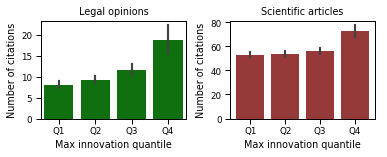

In [92]:
FROM=1980
TO=2010

#df_ops["logdeg"] = np.log1p(df_ops["indeg"])

sns.set_context ("paper")
fig,ax = plt.subplots (1,2, figsize=(6,1.8), sharey=False)
sns.barplot (y="indeg", x="max_prog_q", 
             data=df_ops[(df_ops["year"] > FROM) & (df_ops["year"] <= TO)], 
             ax=ax[0], color='green',
             order=["<25", "<50", "<75", "<100"])
ax[0].set_title ("Legal opinions")
ax[0].set_ylabel ("Number of citations")
ax[0].set_xlabel ("Max innovation quantile")
ax[0].set_xticklabels (["Q1", "Q2", "Q3", "Q4"])

#df_dblp["logdeg"] = np.log1p(df_dblp["indeg"])
sns.barplot (y="indeg", x="max_prog_q", 
             data=df_dblp[(df_dblp["year"] > FROM) & (df_dblp["year"] <= TO)], 
             ax=ax[1], color='brown',
             order=["<25", "<50", "<75", "<100"])
ax[1].set_title ("Scientific articles")
ax[1].set_ylabel ("Number of citations")
ax[1].set_xlabel ("Max innovation quantile")
ax[1].set_xticklabels (["Q1", "Q2", "Q3", "Q4"])

plt.subplots_adjust(wspace=.3)
plt.axis('tight')
plt.savefig('../figs/acl/cites-by-max-progressiveness.pdf', bbox_inches='tight')

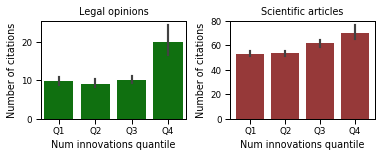

In [93]:
FROM=1980
TO=2010

#df_ops["logdeg"] = np.log1p(df_ops["indeg"])

sns.set_context ("paper")
fig,ax = plt.subplots (1,2, figsize=(6,1.8), sharey=False)
sns.barplot (y="indeg", x="nprog50_q", 
             data=df_ops[(df_ops["year"] > FROM) & (df_ops["year"] <= TO)], 
             ax=ax[0], color='green',
             order=["<25", "<50", "<75", "<100"])
ax[0].set_title ("Legal opinions")
ax[0].set_ylabel ("Number of citations")
ax[0].set_xlabel ("Num innovations quantile")
ax[0].set_xticklabels (["Q1", "Q2", "Q3", "Q4"])

#df_dblp["logdeg"] = np.log1p(df_dblp["indeg"])
sns.barplot (y="indeg", x="nprog50_q", 
             data=df_dblp[(df_dblp["year"] > FROM) & (df_dblp["year"] <= TO)], 
             ax=ax[1], color='brown',
             order=["<25", "<50", "<75", "<100"])
ax[1].set_title ("Scientific articles")
ax[1].set_ylabel ("Number of citations")
ax[1].set_xlabel ("Num innovations quantile")
ax[1].set_xticklabels (["Q1", "Q2", "Q3", "Q4"])

plt.subplots_adjust(wspace=.3)
plt.axis('tight')
plt.savefig('../figs/acl/cites-by-num-progressiveness.pdf', bbox_inches='tight')

**Multivariate regressions**

In [84]:
formulas_ops = ["indeg ~ age + outdeg + ntokens + bows"]

formulas_ops.append(formulas_ops[0]+" + max_prog") # y ~ C(Location, Treatment(reference='China'))
formulas_ops.append(formulas_ops[0]+" + C(max_prog_q, Treatment(reference='<25'))")
formulas_ops.append(formulas_ops[0]+" + nprog50")
formulas_ops.append(formulas_ops[0]+" + C(nprog50_q, Treatment(reference='<25'))")

formulas_dblp = ["indeg ~ age + outdeg + nauthors + ntokens + bows"]
formulas_dblp.append(formulas_dblp[0]+" + max_prog")
formulas_dblp.append(formulas_dblp[0]+" + C(max_prog_q, Treatment(reference='<25'))")
formulas_dblp.append(formulas_dblp[0]+" + nprog50")
formulas_dblp.append(formulas_dblp[0]+" + C(nprog50_q, Treatment(reference='<25'))")

In [46]:
def runAllRegressions (df, formulas):
    results = list ()
    for formula in formulas:
        Y,X = patsy.dmatrices(formula,data=df)
        results.append (sm.GLM(Y, X, family=sm.families.Poisson()).fit())
    return results

In [85]:
results_ops = runAllRegressions (df_ops, formulas_ops)
lls_ops = [result.llf for result in results_ops]

results_dblp = runAllRegressions (df_dblp, formulas_dblp)
lls_dblp = [result.llf for result in results_dblp]

print (lls_ops)
print (lls_dblp)

[-429096.0014844783, -428527.145793919, -422036.76228773687, -427724.1786419009, -423474.2552698895]
[-12922614.06051303, -12897491.767002095, -12896647.477705669, -12890658.970681602, -12912022.637283692]


In [28]:
def goodness_of_fit_tests (lls, formulas):
    for i,ll_0 in enumerate(lls):
        for j,ll_1 in enumerate(lls[:i]):
            chi2_score = ll_0-ll_1
            dof = len(formulas[i].split("+")) - len(formulas[j].split('+'))
            if i == 3: dof += 2 #quartiles
            print(i,j,f'\\chi^2_{dof} = {chi2_score:.2f}, p < {chi2.sf(chi2_score, dof):.3e}')

In [30]:
goodness_of_fit_tests (lls_ops, formulas_ops)

1 0 \chi^2_1 = 568.86, p < 9.959e-126
2 0 \chi^2_1 = 7059.24, p < 0.000e+00
2 1 \chi^2_0 = 6490.38, p < nan
3 0 \chi^2_3 = 1371.82, p < 3.831e-297
3 1 \chi^2_2 = 802.97, p < 4.344e-175
3 2 \chi^2_2 = -5687.42, p < 1.000e+00
4 0 \chi^2_1 = 5621.75, p < 0.000e+00
4 1 \chi^2_0 = 5052.89, p < nan
4 2 \chi^2_0 = -1437.49, p < nan
4 3 \chi^2_0 = 4249.92, p < nan


**Write the results as Latex tables**

In [115]:
def get_latex_table_string (model_results, coeff):
    def get_latex_coeff_table_string (c, model_result):
        return "{0:.3f}".format(round(model_result.params[model_result.model.exog_names.index(c)], 3))
    
    def get_latex_coeff_pair_table_string(c1, c2, model_result):
        if c1 in model_result.model.exog_names:
            return get_latex_coeff_table_string (c1, model_result)
        else:
            return get_latex_coeff_table_string (c2, model_result)
    
    goodnames = {
        "Intercept": "Constant",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<50]", "C(nprog50_q, Treatment(reference='<25'))[T.<50]"): "Prog. Q2",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<75]", "C(nprog50_q, Treatment(reference='<25'))[T.<75]"): "Prog. Q3",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<100]", "C(nprog50_q, Treatment(reference='<25'))[T.<100]"): "Prog. Q4",
        "age": "Age",
        "outdeg": "Outdegree",
        "bows": "BoWs",
        "ntokens": "Length",
        "nauthors": "No. of Authors",
        ("max_prog", "nprog50"): "Prog."
    }

    if type (coeff) == tuple:
        c1, c2 = coeff
        cols = [" "
                if c1 not in model_result.model.exog_names and c2 not in model_result.model.exog_names
                else get_latex_coeff_pair_table_string(c1, c2, model_result)
                for model_result in model_results]
    else:
        cols = [" " 
                if coeff not in model_result.model.exog_names 
                else get_latex_coeff_table_string (coeff, model_result) 
                for model_result in model_results]
    return "&".join ([goodnames[coeff]] + cols) + "\\\\"

def get_latex_stderror_string (model_results, coeff):
    def get_latex_coeff_stderror_string (c, model_result):
        return "({0:.3f})".format(round(model_result.bse[model_result.model.exog_names.index(c)], 3))
    
    def get_latex_coeff_pair_stderror_string(c1, c2, model_result):
        if c1 in model_result.model.exog_names:
            return get_latex_coeff_stderror_string (c1, model_result)
        else:
            return get_latex_coeff_stderror_string (c2, model_result)
        
    goodnames = {
        "Intercept": "Constant",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<50]", "C(nprog50_q, Treatment(reference='<25'))[T.<50]"): "Prog. Q2",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<75]", "C(nprog50_q, Treatment(reference='<25'))[T.<75]"): "Prog. Q3",
        ("C(max_prog_q, Treatment(reference='<25'))[T.<100]", "C(nprog50_q, Treatment(reference='<25'))[T.<100]"): "Prog. Q4",
        "age": "Age",
        "outdeg": "Outdegree",
        "bows": "BoWs",
        "ntokens": "Length",
        "nauthors": "No. of Authors",
        ("max_prog", "nprog50"): "Prog."
    }
    
    if type (coeff) == tuple:
        c1, c2 = coeff
        cols = [" "
                if c1 not in model_result.model.exog_names and c2 not in model_result.model.exog_names
                else get_latex_coeff_pair_stderror_string(c1, c2, model_result)
                for model_result in model_results]
    else:
        cols = [" " 
                if coeff not in model_result.model.exog_names 
                else get_latex_coeff_stderror_string (coeff, model_result)
                #else "({0:.3f})".format(round(model_result.bse[model_result.model.exog_names.index(coeff)], 3)) 
                for model_result in model_results]
    
    #cols = list (map (lambda x:"({0})".format (x), cols))
    
    return "&".join ([" "] + cols) + "\\\\[4pt]"

def get_latex_ll_string (model_results):
    cols = ["{0}".format(str(int(round(model_result.llf)))) for model_result in model_results]
    return "&".join (["Log Lik."] + cols) 

In [125]:
def results_to_latex(model_results, coeffs_order, header_format="lrrrrr"):
    # header part
    #print ("\\begin{tabular}{{0}}".format (header_format))
    print ("\\begin{tabular}" + "{" + "{0}".format (header_format) + "}")
    print ("\\toprule\n")
    print ("& & Models & & & \\\\\n")
    print ("\midrule\n")
    print ("Predictors & M1 & M2 & M3 & M4 & M5\\\\\n")
    print (" & & \\textsc{max-innov} & \\textsc{max-innov} & \\textsc{num-innovs} & \\textsc{num-innovs}\\\\\n")
    print ("\\toprule\n")
    # core part
    
    for coeff in coeffs_order:
        print (get_latex_table_string(model_results, coeff))
        print (get_latex_stderror_string (model_results, coeff))
    
    print (get_latex_ll_string (model_results))    
    print ("\\\\")
    print ("\\bottomrule\n")
    print ("\\end{tabular}\n")

In [128]:
#lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}
results_to_latex (results_ops,
           ["Intercept", "outdeg", "age", "ntokens", "bows", 
            ("max_prog", "nprog50"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<50]", "C(nprog50_q, Treatment(reference='<25'))[T.<50]"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<75]", "C(nprog50_q, Treatment(reference='<25'))[T.<75]"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<100]", "C(nprog50_q, Treatment(reference='<25'))[T.<100]")],
            header_format="lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}"
            )

\begin{tabular}{lp{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}p{1.1cm}}
\toprule

& & Models & & & \\

\midrule

Predictors & M1 & M2 & M3 & M4 & M5\\

 & & \textsc{max-innov} & \textsc{max-innov} & \textsc{num-innovs} & \textsc{num-innovs}\\

\toprule

Constant&1.612&1.597&0.946&1.515&0.963\\
 &(0.003)&(0.003)&(0.007)&(0.004)&(0.007)\\[4pt]
Outdegree&0.019&0.020&0.019&0.020&0.019\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Age&0.011&0.011&0.016&0.012&0.017\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Length&0.000&0.000&0.000&0.000&0.000\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
BoWs&0.000&0.000&0.000&0.000&0.000\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Prog.& &0.001& &0.051& \\
 & &(0.000)& &(0.001)& \\[4pt]
Prog. Q2& & &0.545& &0.577\\
 & & &(0.006)& &(0.006)\\[4pt]
Prog. Q3& & &0.675& &0.615\\
 & & &(0.007)& &(0.007)\\[4pt]
Prog. Q4& & &0.806& &0.745\\
 & & &(0.007)& &(0.008)\\[4pt]
Log Lik.&-429096&-428527&-422037&-427724&-423474
\\
\bottomrule

\end{tabular}



In [129]:
results_to_latex (results_dblp,
           ["Intercept", "outdeg", "nauthors", "age", "ntokens", "bows", 
            ("max_prog", "nprog50"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<50]", "C(nprog50_q, Treatment(reference='<25'))[T.<50]"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<75]", "C(nprog50_q, Treatment(reference='<25'))[T.<75]"), 
            ("C(max_prog_q, Treatment(reference='<25'))[T.<100]", "C(nprog50_q, Treatment(reference='<25'))[T.<100]")]
            )

\begin{tabular}{lrrrrr}
\toprule

& & Models & & & \\

\midrule

Predictors & M1 & M2 & M3 & M4 & M5\\

 & & \textsc{max-innov} & \textsc{max-innov} & \textsc{num-innovs} & \textsc{num-innovs}\\

\toprule

Constant&2.078&2.038&1.959&2.011&2.008\\
 &(0.001)&(0.001)&(0.001)&(0.001)&(0.001)\\[4pt]
Outdegree&0.010&0.010&0.010&0.010&0.010\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
No. of Authors&0.024&0.024&0.024&0.024&0.024\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Age&0.074&0.076&0.078&0.077&0.076\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Length&0.002&0.002&0.002&0.002&0.002\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
BoWs&0.000&0.000&0.000&0.000&0.000\\
 &(0.000)&(0.000)&(0.000)&(0.000)&(0.000)\\[4pt]
Prog.& &0.012& &0.049& \\
 & &(0.000)& &(0.000)& \\[4pt]
Prog. Q2& & &0.085& &0.105\\
 & & &(0.001)& &(0.001)\\[4pt]
Prog. Q3& & &0.145& &0.045\\
 & & &(0.001)& &(0.001)\\[4pt]
Prog. Q4& & &0.246& &0.137\\
 & & &(0.001)& &(0.001)\\[4pt]
Log Lik.&-12922614&-1

In [98]:
results_to_latex (results_dblp,
           ["Intercept", "outdeg", "nauthors", "age", "ntokens", "bows", "max_prog", "C(max_prog_q, Treatment(reference='<25'))[T.<50]", "C(max_prog_q, Treatment(reference='<25'))[T.<75]", "C(max_prog_q, Treatment(reference='<25'))[T.<100]"])

\begin{tabular}{lrrrrr}
\toprule

& & Models & & & \\

\midrule

Predictors & M1 & M2 & M3 & M4 & M5\\

\toprule

Constant&2.0784&2.0375&1.9593&2.0115&2.0082\\
 &(0.0009)&(0.0010)&(0.0011)&(0.0010)&(0.0011)\\[4pt]
Outdegree&0.0104&0.0104&0.0104&0.0104&0.0104\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
No. of Authors&0.0237&0.0237&0.0235&0.0237&0.0235\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
Age&0.0745&0.0765&0.0776&0.0774&0.0760\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
Length&0.0021&0.0019&0.0019&0.0017&0.0020\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
BoWs&0.0001&0.0001&0.0001&0.0001&0.0001\\
 &(0.0000)&(0.0000)&(0.0000)&(0.0000)&(0.0000)\\[4pt]
Progressiveness& &0.0119& & & \\
 & &(0.0000)& & & \\[4pt]
Prog. Q2& & &0.0852& & \\
 & & &(0.0009)& & \\[4pt]
Prog. Q3& & &0.1446& & \\
 & & &(0.0010)& & \\[4pt]
Prog. Q4& & &0.2456& & \\
 & & &(0.0011)& & \\[4pt]
Log Likelihood&-12922614&-12897492&-12896647&-12890659&-12912023
\\
\bottom